In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

## Задание
### Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

## Описание данных
- city – город
- phone – основное устройство, которое использует водитель
- signup_date – дата регистрации аккаунта (YYYYMMDD)
- last_trip_date – дата последней поездки (YYYYMMDD)
- avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- avg_rating_by_driver – средняя оценка поездок водителем
- avg_rating_of_driver – средняя оценка поездок водителя
- surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- avg_surge – средний множитель всплеска за все поездки этого водителя
- trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- weekday_pct – процент поездок пользователя, совершенных в будние дни

In [2]:
df = pd.read_csv('churn.csv', parse_dates=['last_trip_date', 'signup_date'])

In [3]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [4]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

In [5]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Отток - пользователь не заходил в приложение более 30 дней.

In [7]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [8]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [9]:
df.days_since_last_trip

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

In [10]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [11]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')

In [12]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,not_churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,churn
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,not_churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,churn


In [13]:
df.churn.value_counts(normalize=True) * 100

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

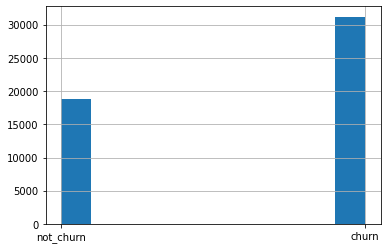

In [14]:
df.churn.hist() 

### Посмотрим, есть ли различия в размерах оттока клиентов в зависимости от платформы. 

In [15]:
df.groupby(['phone', 'churn']).avg_dist.count()

phone    churn    
Android  churn        11876
         not_churn     3146
iPhone   churn        19057
         not_churn    15525
Name: avg_dist, dtype: int64

In [16]:
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


In [17]:
stat, p, dof, expected = st.chi2_contingency(pd.crosstab(df.churn, df.phone))

In [18]:
stat, p

(2558.394212267425, 0.0)

In [19]:
prob = 0.95
if 1 - p >= prob:
    print('Отклоняем H0')
else:
    print('Принимаем H0')

Отклоняем H0


### Т.к. имеем дело с номинативными переменными использовали критерий Хи-квадрат. В результате нулевую гипотезу отклоняем, те взаимосвязь между используемой платформой и оттоком есть.

### Далее проверим, есть ли различия в размерах оттока клиентов в зависимости от города. 

In [20]:
df.groupby(['city', 'churn'], as_index=False).agg({'avg_dist': 'count'}).pivot_table(columns = 'city', index = 'churn', values='avg_dist')

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [21]:
st.chi2_contingency(df.groupby(['city', 'churn'], as_index=False).agg({'avg_dist': 'count'}).pivot_table(columns = 'city', index = 'churn', values='avg_dist'))

(3821.5510225559633,
 0.0,
 2,
 array([[10315.89328,  6320.3096 , 14559.79712],
        [ 6218.10672,  3809.6904 ,  8776.20288]]))

### P-value < 0.05, нулевую гипотезу отклоняем, зависимость между оттоком и городом также имеется.

### Следующим этапом проверим, есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов

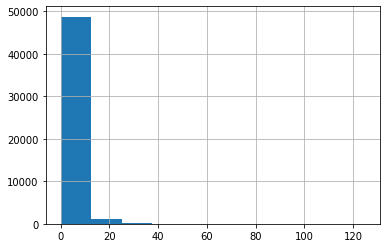

In [22]:
df.trips_in_first_30_days.hist()

In [24]:
st.shapiro(df.trips_in_first_30_days)

ShapiroResult(statistic=0.5649267435073853, pvalue=0.0)

### Распределение не является нормальным, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса

In [29]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [30]:
df.groupby(['city', 'churn'], as_index=False).churn.agg({'count'})

count
city           churn           
Astapor        churn      12306
               not_churn   4228
King's Landing churn       3767
               not_churn   6363
Winterfell     churn      15123
               not_churn   8213

In [25]:
st.kruskal(df[df['city'] == 'Winterfell'].trips_in_first_30_days, df[df['city'] == 'Astapor'].trips_in_first_30_days, df[df['city'] == "King's Landing"].trips_in_first_30_days)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

### Полученные результаты позволяют отклонить нулевую гипотезу p-value < 0.05, те присутствует статистически значимая разница в активности в первые 30 дней с момента регистрации между водителями из разных городов

### Далее проверим может ли отток быть связан с активностью в первые 30 дней после регистрации. Так как мы ранее выяснили, что распределение переменной trips_in_first_30_days не является нормальным, следовательно для проверки гипотезы используем непараметрический критерий - U-критерий Манна-Уитни.

In [32]:
df.groupby('churn').agg({'trips_in_first_30_days': ['sum', 'count', 'mean']})

trips_in_first_30_days                 
                             sum  count      mean
churn                                            
churn                      51738  31196  1.658482
not_churn                  62172  18804  3.306318

In [33]:
st.mannwhitneyu(df[df['churn'] == 'churn'].trips_in_first_30_days, df[df['churn'] == 'not_churn'].trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

### Результат оказался стат. значимым, следовательно значимые различия есть, ушедшие пользователи были менее активны